# Política Monetária e Inflação no Brasil (2016–2018)

Este notebook analisa a relação entre a política monetária brasileira e a inflação,
utilizando dados oficiais do Banco Central do Brasil.

A análise utiliza:
- Selic Over (taxa efetivamente praticada no mercado)
- IPCA mensal
- Cálculo do juro real
- Correlação com defasagem temporal (lag)
- Séries diferenciadas para evitar correlações espúrias

O objetivo é identificar o tempo de transmissão da política monetária sobre a inflação.


In [7]:
# ajusta path
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))

In [8]:
# pip install python-bcb
# pip install scikit-learn

from bcb import sgs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# importa configurações de paleta de cores
import utils.viz_config


In [9]:
# Séries do SGS (Banco Central):
# 432  → Selic Meta (% a.a.) [não utilizada diretamente]
# 4390 → Selic Over (% a.m.)
# 433  → IPCA (% a.m.)

df_bcb = sgs.get(
    {
        'selic_over_%am': 4390,
        'ipca_%am': 433
    },
    start='2016-01-01',
    end='2018-12-31'
)

df_bcb.head()

,selic_over_%am,ipca_%am
Date,,
2016-01-01,1.06,1.27
2016-02-01,1.00,0.90
2016-03-01,1.16,0.43
2016-04-01,1.06,0.61
2016-05-01,1.11,0.78


In [10]:
df_bcb.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36 entries, 2016-01-01 to 2018-12-01
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   selic_over_%am  36 non-null     float64
 1   ipca_%am        36 non-null     float64
dtypes: float64(2)
memory usage: 864.0 bytes


In [11]:
# Conversão de percentual para decimal (base matemática)
df_bcb['ipca_am'] = df_bcb['ipca_%am'] / 100
df_bcb['selic_over_am'] = df_bcb['selic_over_%am'] / 100

df_bcb[['ipca_am', 'selic_over_am']].head()

,ipca_am,selic_over_am
Date,,
2016-01-01,0.0127,0.0106
2016-02-01,0.0090,0.0100
2016-03-01,0.0043,0.0116
2016-04-01,0.0061,0.0106
2016-05-01,0.0078,0.0111


In [12]:
# Garantindo que o índice seja datetime
df_bcb.index = pd.to_datetime(df_bcb.index)
df_bcb.index.name = 'Date'

# As séries IPCA e Selic Over já são mensais na origem (SGS),
# portanto não é necessária reamostragem adicional.
# Porém para fins de comparação com dados comerciais,
# vale normatizar a semântica para "2016-01-31" (exemplo)
df_bcb.index = df_bcb.index.to_period('M').to_timestamp('M')

In [13]:
# Juro real = (1 + juro nominal) / (1 + inflação) - 1
df_bcb['selic_over_real_am'] = (
    (1 + df_bcb['selic_over_am']) /
    (1 + df_bcb['ipca_am'])
) - 1

# Removendo meses sem IPCA (há chance de ocorrer)
df_bcb.dropna(subset=['ipca_am'], inplace=True)

df_bcb.head()


,selic_over_%am,ipca_%am,ipca_am,selic_over_am,selic_over_real_am
Date,,,,,
2016-01-31,1.06,1.27,0.0127,0.0106,-0.002074
2016-02-29,1.00,0.90,0.0090,0.0100,0.000991
2016-03-31,1.16,0.43,0.0043,0.0116,0.007269
2016-04-30,1.06,0.61,0.0061,0.0106,0.004473
2016-05-31,1.11,0.78,0.0078,0.0111,0.003274


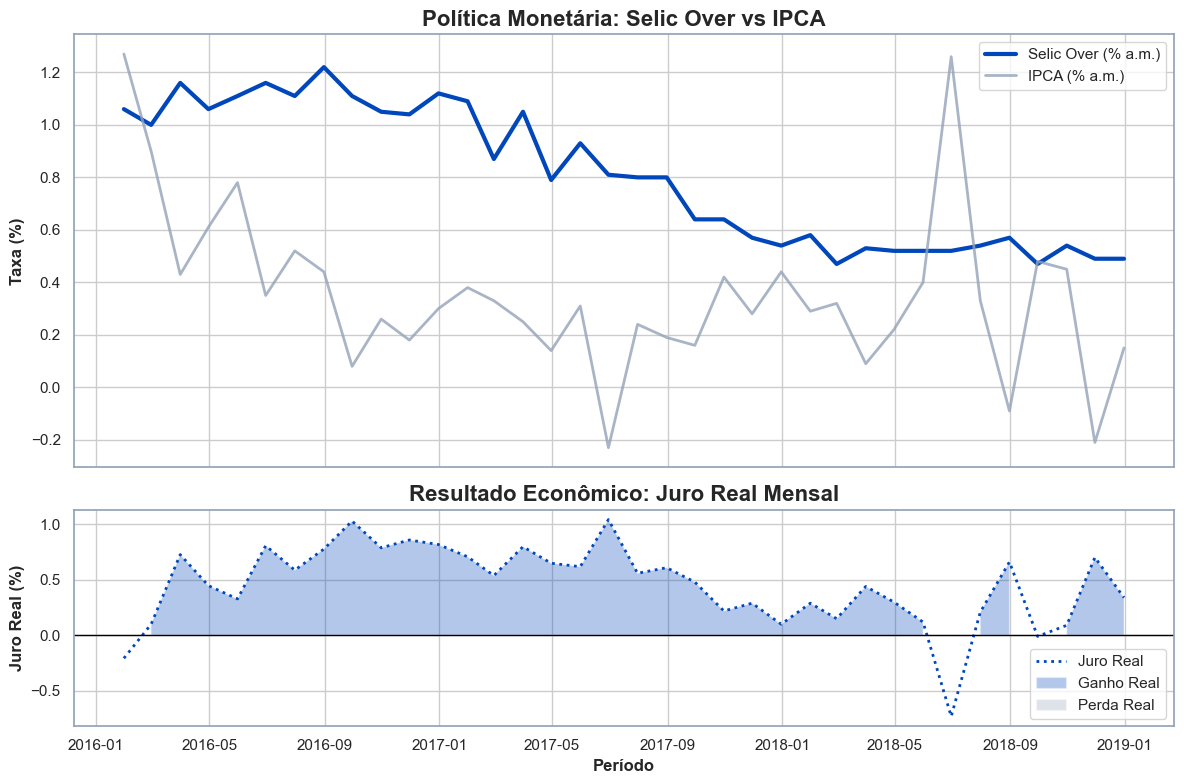

In [14]:
fig, (ax1, ax2) = plt.subplots(
    2, 1, sharex=True, gridspec_kw={'height_ratios': [2, 1]}
)

# Selic Over e IPCA
ax1.plot(df_bcb.index, df_bcb['selic_over_am'] * 100,
         label='Selic Over (% a.m.)', linewidth=3)

ax1.plot(df_bcb.index, df_bcb['ipca_am'] * 100,
         label='IPCA (% a.m.)', linewidth=2, alpha=0.8)

ax1.set_title('Política Monetária: Selic Over vs IPCA')
ax1.set_ylabel('Taxa (%)')
ax1.legend()

# Juro real
juro_real_pct = df_bcb['selic_over_real_am'] * 100

ax2.plot(df_bcb.index, juro_real_pct,
         label='Juro Real', linestyle=':', linewidth=2)

ax2.axhline(0, color='black', linewidth=1)

ax2.fill_between(df_bcb.index, juro_real_pct, 0,
                 where=juro_real_pct >= 0, alpha=0.3, label='Ganho Real')
ax2.fill_between(df_bcb.index, juro_real_pct, 0,
                 where=juro_real_pct < 0, alpha=0.3, label='Perda Real')

ax2.set_title('Resultado Econômico: Juro Real Mensal')
ax2.set_ylabel('Juro Real (%)')
ax2.set_xlabel('Período')
ax2.legend()

plt.tight_layout()
plt.show()


In [15]:
# Utilizamos diferenças para evitar correlações espúrias
lags = np.arange(1, 19)

corrs = [
    df_bcb['ipca_am'].diff()
    .corr(df_bcb['selic_over_real_am'].diff().shift(l))
    for l in lags
]

max_lag = np.nanargmin(corrs) + 1
max_corr = corrs[max_lag - 1]


NameError: name 'PALETA_OLIST' is not defined

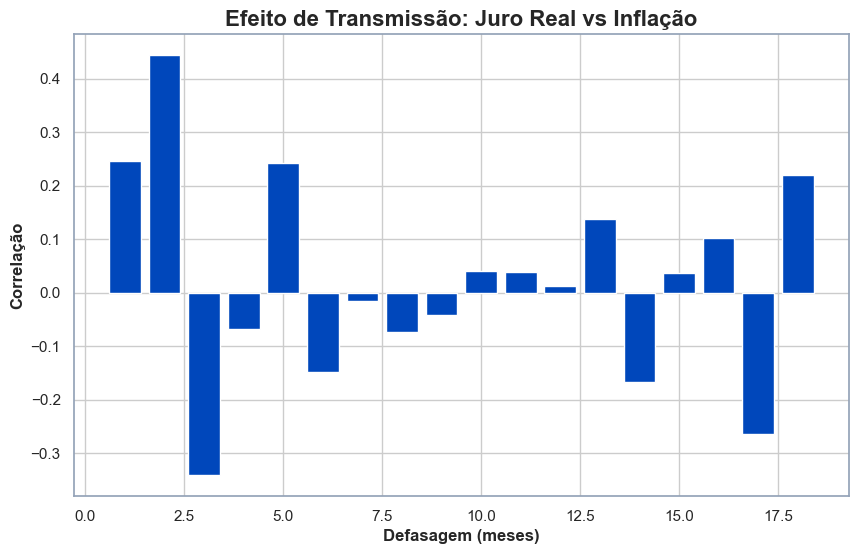

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(lags, corrs)

ax.set_title('Efeito de Transmissão: Juro Real vs Inflação')
ax.set_xlabel('Defasagem (meses)')
ax.set_ylabel('Correlação')

ax.annotate(
    f'Impacto máximo em {max_lag} meses\nCorrelação: {max_corr:.2f}',
    xy=(max_lag, max_corr),
    xytext=(max_lag + 2, max_corr - 0.05),
    arrowprops=dict(arrowstyle='->', color = PALETA_OLIST[0], lw=2),
    fontsize=11, fontweight='bold', color = PALETA_OLIST[0],
    bbox=dict(boxstyle='round', fc='white',ec=PALETA_OLIST[1], alpha=0.9)
)

plt.tight_layout()
plt.show()


In [ ]:
r_quadrado = max_corr ** 2
print(
    f'No melhor lag, cerca de {r_quadrado * 100:.1f}% '
    f'da co-variação linear entre as séries é compartilhada, '
    f'não implicando causalidade.'
)


No melhor lag, cerca de 11.6% da co-variação linear entre as séries é compartilhada, não implicando causalidade.


In [ ]:
# Padronização estatística
# média ≈ 0 | desvio padrão ≈ 1
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df_bcb[['selic_over_std', 'ipca_std', 'selic_over_real_std']] = (
    scaler.fit_transform(
        df_bcb[['selic_over_am', 'ipca_am', 'selic_over_real_am']]
    )
)

df_bcb[['selic_over_std', 'ipca_std', 'selic_over_real_std']].describe().round(2)


,selic_over_std,ipca_std,selic_over_real_std
count,36.00,36.00,36.00
mean,-0.00,-0.00,-0.00
std,1.01,1.01,1.01
min,-1.29,-1.86,-3.28
25%,-1.02,-0.53,-0.65
50%,-0.02,-0.12,0.16
75%,0.99,0.28,0.73
max,1.60,2.92,1.64


In [ ]:
df_entrega = df_bcb.reset_index()
df_entrega.head()

df_entrega.to_csv(
    'analise_ipca_selic_processado.csv',
    index=False
)